# Assignment 9 Starter

The overall goal this week is to simulate a situation where we have abundant unlabeled data, but limited labeled data. Since we cannot afford to train on millions of unlabeled images for one assignment, we instead will go with a "normal" amount of unlabeled data, and very little labeled data.

This could be done for pretty much any modality. For example, we could combine two of our previous assignments -- pretrain a language model on a large unlabeled text dataset, then fine-tune on the IMDB classificatin task. This would hopefully reduce overfitting. But for simplicity, we propose going back to image data with CIFAR10.

This notebook is divided into several parts, based on your likely workflow when approaching this task:
1. Train a classifier from scratch on a limited amount of data. This will likely overfit badly, and lead to bad performance on the test set.
2. Train a self-supervised model on a task of your choice. We propose two options -- an autoencoder, or a "rotation prediction" task. This can be trained on the full dataset, as it does not require labels.
3. Build another classifier that takes the pre-trained self-supervised model as a starting point and merely adds a small classifier layer on top, again training on the small labeled subset.

In the best case, the self-supervised pre-training improves the performance of the classifier trained in step 3, the features learned on the large, unlabeled dataset leading to better generalization. In the worst case, you got to know some alternative model architectures and loss functions, especially in the case of autoencoders. Autoencoder-like structures are also important for architectures like U-Net, as well as several generative models (Variational Autoencoders, Diffusion models).

## Step 1: Obtaining a labeled subset

For this step, we have to limit our labeled dataset. Luckily, this is very simple with `torch` dataloading.

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, Compose

train_transforms = [ToTensor()]
test_transforms = [ToTensor()]

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose(train_transforms))

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose(test_transforms))

100%|██████████| 170M/170M [00:04<00:00, 42.6MB/s]


To control how the DataLoader samples point from the Dataset, it has a `sampler` argument. There is already a `SubsetRandomSampler` which can be used for our purposes. We just have to sample some random indices and provide them; the dataloader will then only take those indices in training.

In [3]:
batch_size = 256

# this is the most important number!
# the fewer samples we take, the more overfitting we will get.
# you can experiment with this number.
# if you take very small numbers, you will have to decrease the batch size accordingly.
n_labeled_subset = 1000  # use None to take all labeled samples
n_data_total = 50000  # CIFAR10

seed = 12  # change to get different subsets
if n_labeled_subset is not None:
    np.random.seed(seed)
    random_inds = np.random.choice(n_data_total, size=n_labeled_subset, replace=False)
    train_sampler = SubsetRandomSampler(random_inds)
else:
    train_sampler = None

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True if n_labeled_subset is None else False,
                              drop_last=True, sampler=train_sampler, num_workers=16)
test_dataloader = DataLoader(test_data, batch_size=batch_size,
                             num_workers=16)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
Shape of y: torch.Size([256]) torch.int64


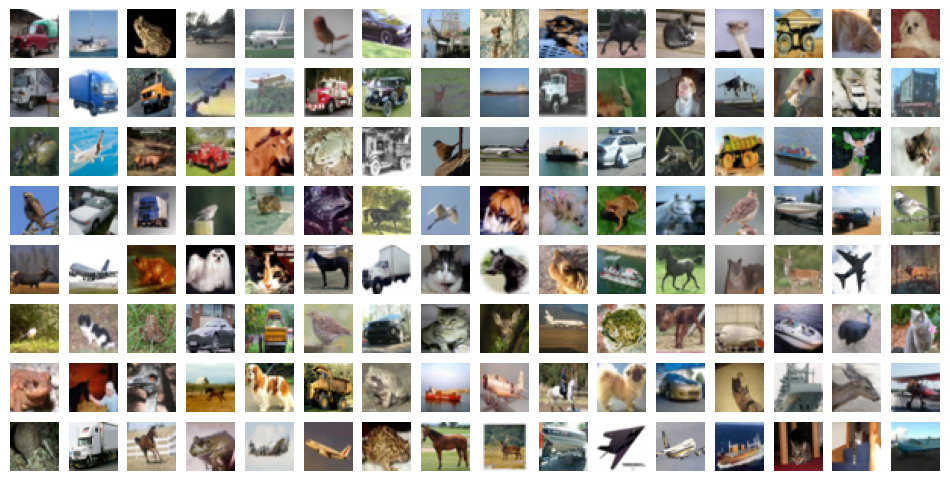

In [4]:
# look at some of images.
# if you run this several times, you should see the same images quite often.
# that's because we made our overall dataset much smaller.
for X, _ in train_dataloader:
    plt.figure(figsize=(12, 6))
    for ind, img in enumerate(X[:128]):
        plt.subplot(8, 16, ind+1)
        plt.imshow(img.permute((1, 2, 0)))
        plt.axis("off")
    plt.show()
    break

After this point, you can train a classifier as usual. CIFAR10, 10 classes, etc. We have plenty of code examples for this already, e.g. in the leadup to assignments 4 and 5. You could take any of those models. But you will have to train from scratch! Do not load the weights given on E-Learning. Training should be quite fast due to the small dataset size. You could further reduce model size to speed up the process.

Note that, with less data, one epoch is much fewer steps, so you may need to increase the number of epochs as well as the `EarlyStopping` patience.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


def conv_layer(previous_filters, current_filters, kernel_size):
    return nn.Sequential(nn.Conv2d(previous_filters, current_filters, kernel_size, padding="same"),
                         nn.BatchNorm2d(current_filters),
                         nn.Mish())


def vgg_level(n_layers, prev_filters, current_filters, kernel_size):
    level = nn.Sequential()
    for layer_ind in range(n_layers):
        level.append(conv_layer(prev_filters if layer_ind == 0 else current_filters, current_filters, kernel_size))
    level.append(nn.MaxPool2d(2, ceil_mode=True))
    return level


def vgg_body(n_levels, layers_per_level, start_filters, kernel_size, input_channels=3, filter_multiplier=2):
    body = nn.Sequential()
    current_filters = start_filters
    previous_filters = input_channels

    for level_ind in range(n_levels):
        body.append(vgg_level(layers_per_level, previous_filters, current_filters, kernel_size))
        previous_filters = current_filters
        current_filters *= 2
    return body


def hidden_linear(dim):
    layer = nn.Sequential(nn.LazyLinear(dim),
                          nn.BatchNorm1d(dim),
                          nn.Mish())
    return layer


n_levels = 4
layers_per_level = 3
start_filters = 64
kernel_size = 3
linear_dim = 1024

model = nn.Sequential()
model.append(vgg_body(n_levels, layers_per_level, start_filters, kernel_size))
model.append(nn.Flatten())
model.append(hidden_linear(linear_dim))
model.append(nn.Linear(linear_dim, 10))

model = model.to(device)
with torch.no_grad():
    model(next(iter(train_dataloader))[0].to(device))
print(model)


def glorot_init(layer: nn.Module):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)


def accuracy(labels: torch.tensor,
             outputs: torch.tensor) -> torch.tensor:
    predictions = torch.argmax(outputs, axis=-1)
    matches = labels == predictions
    return matches.float().mean()

Using cuda device
Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [6]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

In [7]:
class EarlyStopping:
    def __init__(self, model, patience, direction="min", min_delta=0.0001, verbose=False):
        if direction not in ["min", "max"]:
            raise ValueError("direction should be 'min' or 'max', you passed {}".format(direction))
        self.best_state_dict = {key: None for key in model.state_dict()}
        self.best_value = np.inf if direction == "min" else -np.inf
        self.direction = direction
        self.min_delta = min_delta
        self.model = model

        self.patience = patience
        self.disappointment = 0
        self.verbose = verbose

    def update(self, value):
        if ((self.direction == "min" and value < self.best_value - self.min_delta)
            or (self.direction == "max" and value > self.best_value + self.min_delta)):
            self.best_value = value
            for key in model.state_dict():
                self.best_state_dict[key] = model.state_dict()[key].clone()
            self.disappointment = 0
            if self.verbose:
                print("New best value found; no longer disappointed")
            return 0
        else:
            self.disappointment += 1
            if self.verbose:
                print("EarlyStopping disappointment increased to {}".format(self.disappointment))

            if self.disappointment > self.patience:
                if self.verbose:
                    print("EarlyStopping has become too disappointed; now would be a good time to cancel training")
                    print("Restoring best model from state_dict")
                self.model.load_state_dict(self.best_state_dict)
                return 1
            else:
                return 0

In [8]:
from time import perf_counter

def train_model(model: nn.Module,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler.LRScheduler,
                training_loader: DataLoader,
                validation_loader: DataLoader,
                n_epochs: int,
                verbose: bool = True):
    n_training_examples = len(training_loader.dataset)
    batches_per_epoch = n_training_examples // training_loader.batch_size
    print("Running {} epochs at {} steps per epoch.".format(n_epochs, batches_per_epoch))

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopper = EarlyStopping(model, patience=9, verbose=verbose)

    for epoch in range(n_epochs):
        if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")

        start_time = perf_counter()
        epoch_train_losses = []
        epoch_train_accuracies = []

        model.train()
        for batch_ind, (input_batch, label_batch) in enumerate(training_loader):
            batch_loss, batch_accuracy = train_step(input_batch, label_batch, model, loss_fn, optimizer)
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accuracies.append(batch_accuracy.item())

        end_time = perf_counter()
        time_taken = end_time - start_time

        # evaluate after each epoch
        val_loss, val_accuracy = evaluate(model, validation_loader, loss_fn)
        scheduler.step(val_loss)

        should_stop = early_stopper.update(val_loss)

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())
        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(np.mean(epoch_train_accuracies))

        if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_losses[-1], val_losses[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_accuracies[-1], val_accuracies[-1]))
            print("\tLR is now {}".format(scheduler.get_last_lr()[0]))

        if should_stop:
            print("Early stopping...")
            break

    return {"train_loss": np.array(train_losses), "train_accuracy": np.array(train_accuracies),
            "val_loss": np.array(val_losses), "val_accuracy": np.array(val_accuracies)}


def train_step(input_batch, label_batch, model, loss_fn, optimizer):
    input_batch = input_batch.to(device)
    label_batch = label_batch.to(device)
    output_batch = model(input_batch)
    batch_loss = loss_fn(output_batch, label_batch)

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        batch_accuracy = accuracy(label_batch, output_batch)
    return batch_loss, batch_accuracy


def evaluate(model, dataloader, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for input_batch, label_batch in dataloader:
            input_batch = input_batch.to(device)
            label_batch = label_batch.to(device)
            predictions = model(input_batch)
            val_loss += loss_fn(predictions, label_batch)
            correct += (predictions.argmax(axis=1) == label_batch).type(torch.float).sum()

        val_loss /= num_batches
        val_accuracy = correct / size
    return val_loss, val_accuracy

def evaluate_with_translation(model, dataloader, loss_fn, translate_x, translate_y):
        model.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        val_loss, correct = 0, 0

        with torch.no_grad():
            for input_batch, label_batch in dataloader:
                input_batch = input_batch.to(device)
                input_batch = affine(input_batch, angle=0, scale=1, shear=0., translate=[translate_x, translate_y])
                label_batch = label_batch.to(device)
                predictions = model(input_batch)
                val_loss += loss_fn(predictions, label_batch).item()
                correct += (predictions.argmax(1) == label_batch).type(torch.float).sum().item()

        val_loss /= num_batches
        correct /= size
        return val_loss, correct

In [ ]:
metrics = train_model(model, loss_fn, optimizer, scheduler, train_dataloader, test_dataloader, n_epochs=300)

Running 300 epochs at 195 steps per epoch.
Starting epoch 1... New best value found; no longer disappointed
Time taken: 1.5416958019999925 seconds
	Train/val loss: 2.5309907595316568 / 2.342471122741699
	Train/val accuracy: 0.15625 / 0.09999999403953552
	LR is now 0.001
Starting epoch 2... EarlyStopping disappointment increased to 1
Time taken: 0.8902071109999952 seconds
	Train/val loss: 2.111046552658081 / 2.504098415374756
	Train/val accuracy: 0.2421875 / 0.09999999403953552
	LR is now 0.001
Starting epoch 3... EarlyStopping disappointment increased to 2
Time taken: 0.9577188690000185 seconds
	Train/val loss: 1.9050782521565754 / 3.0190799236297607
	Train/val accuracy: 0.2890625 / 0.1054999977350235
	LR is now 0.001
Starting epoch 4... EarlyStopping disappointment increased to 3
Time taken: 0.8703715550000197 seconds
	Train/val loss: 1.7640851736068726 / 3.2990424633026123
	Train/val accuracy: 0.34765625 / 0.11490000039339066
	LR is now 0.001
Starting epoch 5... 

In [ ]:
evaluate(model, test_dataloader, loss_fn)

## Step 2: Self-supervised model

We propose two options here. Autoencoder or rotation prediction.


### Option 1: Autoencder

There are two main aspects: Architecture, and training. Let's do training first since it's quite simple:

#### Training autoencoders
An autoencoder is a model that should return an output equal to the input. At the same time, it should be limited in some way to force the model to actually learn something about the input, and not just pass it through directly. For example, a "representational bottleneck", i.e. smaller hidden space than input, forces the model to compress the input, which in turn requires learning.

You should be able to reuse much of your previous training code, but there are few changes to be made.
- There are no labels. The targets are equal to the inputs.
- The loss function has to quantify the difference between the model outputs and the targets. There are many choices here. A simple one is `nn.MSELoss`, which computes the squared difference at each pixel in the image, and then computes the mean over the image.

Note that "accuracy" makes no sense for an autoencoder and you should not compute this.

#### Architecture
The autoencoder has to return outputs equal to the shape of the inputs. When using a CNN, this means we have to somehow revert the common pooling (or strided convolution) operations. By far the easiest way to do this is to use layers like `nn.Upsample(scale_factor=2)`. This will upsample the input by a factor of 2. There is also "transposed convolution", `nn.ConvTranspose2d`. This is a kind of "inverse convolution" that actually leads to a _larger_ output if you supply a stride. However, this is a bit fiddly to get right, so maybe stick with `Upsampling`. If you are interested in the difference between the two, there is [a nice Distill post on this](https://distill.pub/2016/deconv-checkerboard/).

In general, you should create an `encoder` model that maps to a lower-dimensional space, and then a separate `decoder` that maps back to the original image size. Then create an `autoencoder` as `nn.Sequential(encoder, decoder)`. The decoder is often defined as a "mirror" of the encoder. So: Convolutions with Upsampling, and _decreasing_ the number of filters after upsampling. The final layer has to map back to 3 channels for color images.

Splitting the architecture into two parts then lets you easily store the weights of only the encoder (remember the `state_dict`).

For "inspiration" here is some code that basically reverts the usual convolutions from the basic CNN model used in assignment 4. `conv_layer` is defined in those older notebooks; it is a sequence of Convolution -> Batchnorm -> Activation.

In [ ]:
def decoder_level(n_layers: int,
                  prev_filters: int,
                  current_filters: int,
                  kernel_size: int) -> nn.Module:
    level = nn.Sequential()
    level.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False))
    for layer_ind in range(n_layers):
        level.append(conv_layer(
            prev_filters if layer_ind == 0 else current_filters,
            current_filters,
            kernel_size
        ))
    return level


def decoder_body(n_levels: int,
                 layers_per_level: int,
                 start_filters: int,
                 kernel_size: int,
                 input_channels: int,
                 filter_multiplier: int = 2) -> tuple[nn.Sequential, int]:
    body = nn.Sequential()
    current_filters = start_filters // (2 ** (n_levels - 1))
    previous_filters = input_channels

    for level_ind in range(n_levels):
        body.append(decoder_level(layers_per_level, previous_filters, current_filters, kernel_size))
        previous_filters = current_filters
        current_filters //= 2

    return body, previous_filters

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,
                 n_levels=4,
                 layers_per_level=3,
                 start_filters=64,
                 kernel_size=3,
                 linear_dim=1024):
        super().__init__()


        self.encoder_body = vgg_body(n_levels, layers_per_level, start_filters, kernel_size)

        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 32, 32)
            encoded_output_shape = self.encoder_body(dummy_input).shape


        flattened_size = encoded_output_shape[1] * encoded_output_shape[2] * encoded_output_shape[3]


        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            hidden_linear(linear_dim),
            nn.Linear(linear_dim, linear_dim // 2)
        )


        self.decoder_fc = nn.Sequential(
            nn.Linear(linear_dim // 2, linear_dim),
            hidden_linear(linear_dim),
            nn.Linear(linear_dim, flattened_size)
        )


        self.decoder_body, self.final_decoder_channels = decoder_body(
            n_levels, layers_per_level, start_filters, kernel_size,
            input_channels=encoded_output_shape[1]
        )


        self.final_layer = nn.Conv2d(self.final_decoder_channels, 3, kernel_size=1)
        self.encoded_output_shape = encoded_output_shape


    def forward(self, x):
        x = self.encoder_body(x)
        x = torch.flatten(x, 1)
        x = self.encoder_fc(x)
        x = self.decoder_fc(x)
        x = x.view(-1, self.encoded_output_shape[1], self.encoded_output_shape[2], self.encoded_output_shape[3])  # match decoder start
        x = self.decoder_body(x)
        x = self.final_layer(x)
        return torch.sigmoid(x)

In [ ]:
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    total_loss = 0
    for imgs, _ in train_dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Autoencoder] Epoch {epoch+1}, Loss: {total_loss / len(train_dataloader):.4f}")


In [ ]:
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            x = model.encoder_body(imgs)
            x = torch.flatten(x, 1)
            x = model.encoder_fc(x)
            features.extend(x.cpu().numpy())
            labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_encoded, y_encoded = extract_features(autoencoder, train_dataloader)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_encoded, y_encoded)
print("Classifier Accuracy using Autoencoder features:", clf.score(X_encoded, y_encoded))


### Option 2: Rotation prediction

This one is just another classification problem. We just make our own labels: Each image is randomly rotated by a multiple of 90 degrees (including 0), and the model has to predict which rotation was applied. This forces it to learn something about what images normally look like. Thus:
- Nothing changes about training. You have four classes, for rotations of 0, 90, 180, or 270 degrees. Cross-entropy!
- The architecture needs to be something with four outputs.

You should construct the model in a way that you can easily "remove" the final classification layer. E.g. first build the `body` with all layers except the final one, then `classifier = nn.Sequential(body, classfication_layer)`. This allows you to easily store just the `body` and put a different classifier on top.

Below is code to actually implement the rotation prediction "dataset". First off is a transform you should apply to your training/test dataset. This randomly rotates the images and replaces the labels by an index from 0-3 indicating the rotation. You could still add more transforms like scaling, translating, color shifts...

In [ ]:
import os
import random
from torchvision.transforms.v2 import Compose, RandomRotation
from torchvision.transforms.v2.functional import rotate
from torch.utils.data import Dataset

class RotateLabel(RandomRotation):
    def __init__(self, child_transform, **kwargs):
        super().__init__(**kwargs)
        self.child_transform = child_transform
        self.tot = ToTensor()

    def forward(self, img, label):
        img = self.child_transform(img)
        fill = self.fill
        if isinstance(img, torch.Tensor):
            if isinstance(fill, (int, float)):
                fill = [float(fill)] * 3  # magic number: number of color channels in CIFAR10
            else:
                fill = [float(f) for f in fill]
        angle_choice = torch.randint(0, 4, ())
        angle = angle_choice*90


        return self.tot(rotate(
            img, angle, self.interpolation, self.expand, self.center, fill)), angle_choice

train_transforms = [lambda x: x]  # nothing
train_rotator = RotateLabel(Compose(train_transforms), degrees=180)
test_rotator = RotateLabel(Compose(test_transforms), degrees=180)

Next, the `CIFAR10` dataset inherits from `VisionDataset`, which actually has a `transforms` argument which allows to transform and return images and labels at the same time, which is what we need... But _for some reason_, the `CIFAR10` class does not support this. So we implement our own -- use this instead of `CIFAR10` for the rotation prediction task.

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
Shape of y: torch.Size([256]) torch.int64


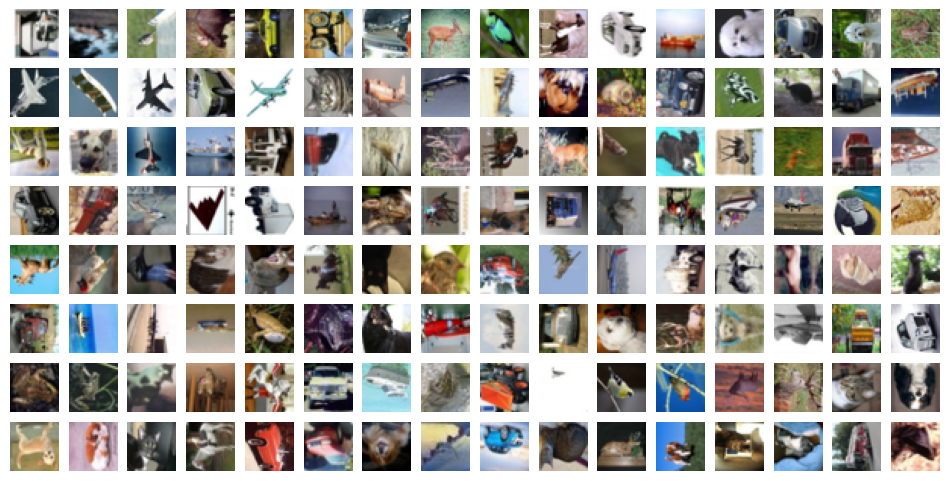

In [17]:
# for some godforsaken reason, the vision dataset base class supports "transforms"
# but the inherited CIFAR10 class does not...........................
from PIL import Image
import pickle


class CIFAR10Better(datasets.CIFAR10):
    def __init__(self,
                 root,
                 train: bool = True,
                 download: bool = False,
                 transforms=None):
        datasets.VisionDataset.__init__(self, root, transforms=transforms)
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError("Dataset not found or corrupted. You can use download=True to download it")

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, "rb") as f:
                entry = pickle.load(f, encoding="latin1")
                self.data.append(entry["data"])
                if "labels" in entry:
                    self.targets.extend(entry["labels"])
                else:
                    self.targets.extend(entry["fine_labels"])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()

    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target


# usage e.g.
train_data = CIFAR10Better(
    root="data",
    train=True,
    download=True,
    transforms=train_rotator)

test_data = CIFAR10Better(
    root="data",
    train=False,
    download=True,
    transforms=test_rotator)


batch_size = 256
n_labeled_subset = 256

seed = 12  # change to get different subsets
if n_labeled_subset is not None:
    np.random.seed(seed)
    random_inds = np.random.choice(50000, size=n_labeled_subset, replace=False)
    train_sampler = SubsetRandomSampler(random_inds)
else:
    train_sampler = None


# Create data loaders.

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True if n_labeled_subset is None else False,
                              drop_last=True, sampler=train_sampler, num_workers=16)
test_dataloader = DataLoader(test_data, batch_size=batch_size,
                             num_workers=16)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


# look at some of the images.
# there should be plenty of rotated images in here.
for X, _ in train_dataloader:
    plt.figure(figsize=(12, 6))
    for ind, img in enumerate(X[:128]):
        plt.subplot(8, 16, ind+1)
        plt.imshow(img.permute((1, 2, 0)))
        plt.axis("off")
    plt.show()
    break

In [18]:
# Build the rotation prediction model
rotation_body = vgg_body(n_levels, layers_per_level, start_filters, kernel_size).to(device)

rotation_model = nn.Sequential()
rotation_model.append(rotation_body)
rotation_model.append(nn.Flatten())
rotation_model.append(hidden_linear(linear_dim))
rotation_model.append(nn.Linear(linear_dim, 4))  # 4 rotations: 0°, 90°, 180°, 270°

rotation_model = rotation_model.to(device)

# test forward pass
with torch.no_grad():
    rotation_model(next(iter(train_dataloader))[0].to(device))

print(rotation_model)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

In [19]:
# Train the rotation prediction model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rotation_model.parameters(), lr=1e-3)

for epoch in range(5):
    rotation_model.train()
    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = rotation_model(imgs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

Epoch 1: Loss = 1.4183
Epoch 2: Loss = 2.4314
Epoch 3: Loss = 2.9056
Epoch 4: Loss = 1.4217
Epoch 5: Loss = 1.3088


In [20]:
# Reuse the trained body for normal CIFAR10 classification
clf_head = nn.Linear(linear_dim, 10).to(device)

classification_model = nn.Sequential(rotation_body, nn.Flatten(), hidden_linear(linear_dim), clf_head).to(device)

print(classification_model)

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

## Step 3 Build a classifier

To keep an overview, it's best to train the above self-supervised model in a separate file. Then save the state dict of the `encoder` or `body` of the model.

Next, you go back to your original 10-class CIFAR10 classifier that is trained only on a small labeled subset. After creating the model, load the state dict of the encoder/body into the classifier, except for the final layer. You can achieve this by again creating this classifier like `nn.Sequential(body, classfication_layer)` and only loading the `state_dict` into the `body`.

Of course, for this to work, **the pre-trained encoder or body has to have the same structure as your classifier body!** Else, the weights don't match up! Thus, however you originally constructed your CIFAR10 classifier, you should create the autoencoder encoder and/or rotation prediction body in the same way!

Now set up an optimizer that only trains the classifier weights. For example, if your model is `classifier = nn.Sequential(body, classfication_layer)`, you could build `AdamW(classifier[1:].parameters()`. This will exclude the first "layer" of the classifier (which is the _entire_ body) from training.

Finally, train this model on the small labeled CIFAR10 subset again. Compare performance to training from scratch. What do you observe?

In [21]:
# FOR EXAMPLE
encoder_only = model[0]  # this is the self-supervised model
torch.save(rotation_body.state_dict(), "rotation_body_pretrained.pt")


# then in the classifier file
encoder = vgg_body(n_levels, layers_per_level, start_filters, kernel_size).to(device)
encoder.load_state_dict(torch.load("rotation_body_pretrained.pt"))

classifier_head = nn.Linear(linear_dim, 10).to(device)

# this is the CIFAR10 10-class classifier
model = nn.Sequential(encoder, nn.Flatten(),hidden_linear(linear_dim),classifier_head)
model = model.to(device)

print(model)

for param in encoder.parameters():
    param.requires_grad = False
# optimizer excludes encoder
# note: now weight_decay. feels a bit overkill since we only train one layer anyway
optimizer = torch.optim.AdamW(model[2:].parameters(), lr=0.01, weight_decay=0.00, amsgrad=True)

loss_fn = nn.CrossEntropyLoss()
# now you can train as usual

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

In [22]:
for epoch in range(200):
    model.train()
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        out = model(X)
        loss = loss_fn(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            preds = torch.argmax(out, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    train_acc = 100 * correct / total

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}, Train Accuracy = {train_acc:.2f}%")

Epoch 1: Loss = 2.3708, Train Accuracy = 27.73%
Epoch 2: Loss = 1.8640, Train Accuracy = 25.39%
Epoch 3: Loss = 1.9244, Train Accuracy = 25.78%
Epoch 4: Loss = 1.9275, Train Accuracy = 21.88%
Epoch 5: Loss = 1.5983, Train Accuracy = 28.12%
Epoch 6: Loss = 1.5636, Train Accuracy = 30.47%
Epoch 7: Loss = 1.4312, Train Accuracy = 26.56%
Epoch 8: Loss = 1.4313, Train Accuracy = 28.52%
Epoch 9: Loss = 1.4166, Train Accuracy = 28.12%
Epoch 10: Loss = 1.6184, Train Accuracy = 23.44%
Epoch 11: Loss = 1.2944, Train Accuracy = 25.78%
Epoch 12: Loss = 1.4048, Train Accuracy = 21.88%
Epoch 13: Loss = 1.5707, Train Accuracy = 30.08%
Epoch 14: Loss = 1.4802, Train Accuracy = 28.12%
Epoch 15: Loss = 1.3294, Train Accuracy = 30.08%
Epoch 16: Loss = 1.3761, Train Accuracy = 35.16%
Epoch 17: Loss = 1.3942, Train Accuracy = 25.39%
Epoch 18: Loss = 1.5033, Train Accuracy = 26.95%
Epoch 19: Loss = 1.2816, Train Accuracy = 30.47%
Epoch 20: Loss = 1.2844, Train Accuracy = 25.78%
Epoch 21: Loss = 1.2343, Trai

## Final Words

Unfortunately, it may well be that your fine-tuning performs worse than just training from scratch. :( This may be because the features learned on the self-supervised task are not immediately usable for object classification. Self-supervised learning likely really starts scaling at very large amounts of data (see LLMs). You could also extend your experiments, e.g.

- Use more than just one layer as the "head" (i.e. the part that you put on top of the `body`). This gives the fine-tuning process more weights, and thus more flexibility.
- "Unfreeze" some of the deeper layers in the body. For example, adding `body[-3:].parameters()` would allow the optimizer to fine-tune the last three layers of the body in addition to the classification head. The extreme would be to just fine-tune the entire body as well, but this risks overfitting.

In any case, there are some useful takeaways just from doing the task, even in case of a negative result:
- Finally using something-that-isn't-crossentropy to train the autoencoder.
  - The rotation prediction could also be framed as a regression task where any rotation from 0-360 degrees is allowed and needs to be predicted. But this comes with additional issues, e.g. black borders being introduced which would make the prediction rather easy, and the loss function is a bit more complex.
- Getting to know layers like Upsample+Convolution or Transposed Convolution.
- "Creating your own labels" from data

## References

1. **Tutorial: Deep Autoencoders on CIFAR-10**  
https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/AE_CIFAR10.ipynb

2. **Vipul Vaibhaw (2018), Building Autoencoder in PyTorch**:
https://vaibhaw-vipul.medium.com/building-autoencoder-in-pytorch-34052d1d280c

3. **GeeksforGeeks (2025), Implementing an Autoencoder in PyTorch**:
https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/


